<a href="https://colab.research.google.com/github/mayursrt/dog-breed-identification/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. Data
The data we're using is from Kaggle's dog breed identification competition. You can get the data here:

https://www.kaggle.com/c/dog-breed-identification/data

3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).


### Getting the workspace ready
First Import all the packages needed for the task:
* TensorFlow 2.x
* TensorFlow Hub

Also check if you're using a GPU.


In [1]:
# import packages and check their versions
import tensorflow as tf
import tensorflow_hub as hub
print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

TensorFlow version: 2.4.1
TensorFlow Hub version: 0.11.0


In [2]:
# check GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


**NOTE:** This project will not be able to run if there is no GPU available. If using Google Colab, Goto Runtime > Change Runtime Type > Select GPU.

### Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [3]:
# Checkout the labels of the data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Breed Identification using Tensorflow/data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     a8cb1a353bf80b0c55919bf5d929c694  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [4]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

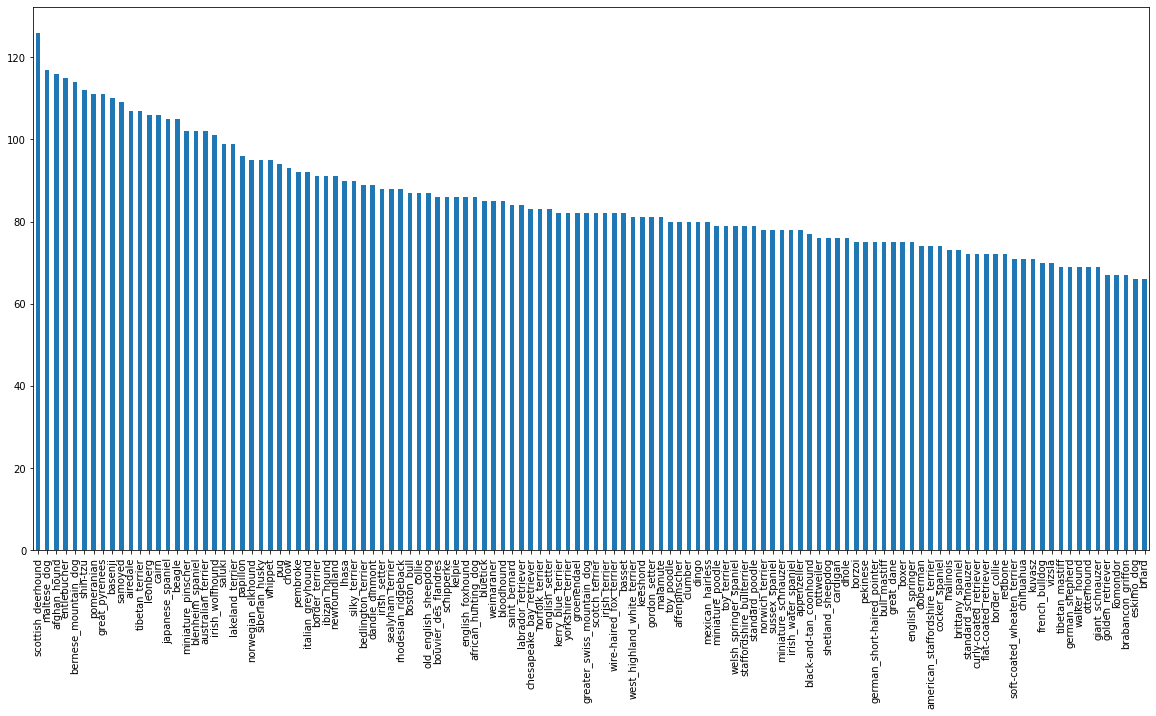

In [5]:
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10));

In [6]:
# median labels per breed to get distribution of data
labels_csv['breed'].value_counts().median()

82.0

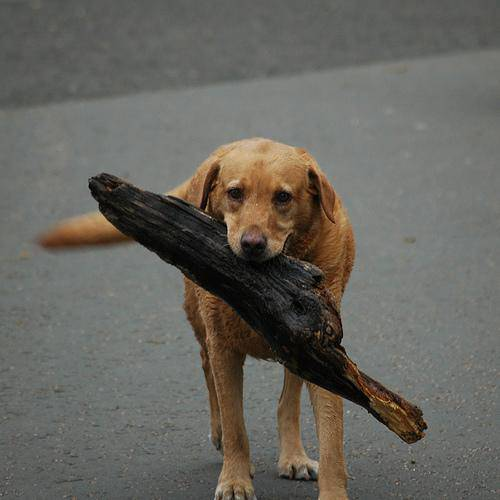

In [7]:
 # View an Image
 from IPython.display import Image
 Image('drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg')



### Getting images and their labels
Get the list of all image file pathnames.

In [8]:
# create pathnames for image ids
filenames = ['drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/' + fname + '.jpg' for fname in labels_csv ['id']]
filenames[:10]

['drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Breed Id

In [9]:
# check if the number of filenames match the number of actual image files(this can be caused by incomplete upload of the files)
import os
if len(os.listdir('drive/MyDrive/Dog Breed Identification using Tensorflow/data/train/')) == len(filenames):
  print('Filenames match actual amount of files..!!! you can proceed.')
else:
  print('Filenames do not match the actual amount of files..!! please try and reupload the data directory')

Filenames match actual amount of files..!!! you can proceed.


Preparing the labels

In [10]:
import numpy as np
# transforming labels so that they can be used.
labels = np.array(labels_csv['breed'])  ## can also use labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [11]:
#check length of labels
len(labels)

10222

In [12]:
# see if the number of labels match the length of filenames
if len(labels) == len(filenames):
  print('Filenames match actual amount of files..!!! you can proceed.')
else:
  print('Filenames do not match the actual amount of files..!! please try and reupload the data directory')

Filenames match actual amount of files..!!! you can proceed.


In [13]:
#find unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [14]:
#len of unique breeds
len(unique_breeds)

120

In [15]:
#turning a label into a boolean array
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [16]:
# likewise turning all labels in boolean array
labels_bool = [labels == unique_breeds for labels in labels]
labels_bool[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
# turning boolean array into integers #maybe not needed

print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(labels_bool[0].argmax())
print(labels_bool[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating validation set 
since we do not have validation set in our dataset, we need to create one so that we can run validation tests on the validation set.

we can use `train_test_split` for this job

In [18]:
# split into X and y

X = filenames
y = labels_bool

Starting off with ~1000 images since we need to reduce time taken for running the model

In [19]:
# set number of images used for experimenting
# if using jupyter notebook, set images number direct to a value
#NUM_IMAGES = 1000
# OR
# we can also use slider to set the number of images and increase them on the go if you are using Google Colab.
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10222, step:500}

In [20]:
# spliting data into train and validation set

from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
np.random.seed(42)
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocessing Images(turning Images into Tensors)
Since we might need to reuse the functionality of preprocessing the data, we need to create a function so that it is easy to reuse it.


To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
1. Use TensorFlow to read the file and save it to a variable, `image`
1. Turn our `image` (a jpg) into Tensors
1. Normalize our image (convert color channel values from from 0-255 to 0-1).
1. Resize the `image` to be a shape of (224, 224)
1. Return the modified `image`

In [21]:
# lets look how image looks in a numpy array vs in a tensor
from matplotlib.pyplot import imread
image = imread(filenames[45])
# image in form of a numpy array
image[:2]

array([[[85, 66, 60],
        [86, 67, 61],
        [84, 65, 59],
        ...,
        [41, 26, 23],
        [48, 33, 30],
        [51, 36, 33]],

       [[85, 66, 60],
        [89, 70, 64],
        [88, 69, 63],
        ...,
        [51, 36, 33],
        [58, 43, 40],
        [61, 46, 43]]], dtype=uint8)

In [22]:
#image in form of a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[85, 66, 60],
        [86, 67, 61],
        [84, 65, 59],
        ...,
        [41, 26, 23],
        [48, 33, 30],
        [51, 36, 33]],

       [[85, 66, 60],
        [89, 70, 64],
        [88, 69, 63],
        ...,
        [51, 36, 33],
        [58, 43, 40],
        [61, 46, 43]]], dtype=uint8)>

In [23]:
# creating the function

# Define image size
IMG_SIZE = 224

# write function
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # turn jpg image to numerical tensor with 3 color channels RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # convert colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize image
  image =  tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  # return image

  return image

### Turning data into batches 

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: `(image, label)`.

In [24]:
# Create func to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [25]:
# Create function to turn all the data into batches.

# Define batch size
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # if the data is a test dataset, we will not have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # if the data is validation data, we don't need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # else training data 
  else:
    print('Creating train data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [26]:
# create training and validation data batches

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating train data batches...
Creating valid data batches...


### Visualizing Data Batches

The data is batches, now we can visualize these batches so to understand it better.



In [27]:
import matplotlib.pyplot as plt

# create func for viewing images in a data batch.
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # show image
    plt.imshow(images[i])
    # add title as image label
    plt.title(unique_breeds[labels[i].argmax()])
    # gridlines off
    plt.axis('off')

Since the train data is in the form of batches, we need to revert it back to numpy arrays to visualize it. We do it by using `next()` function which Return the next item from the iterator. That paired with `as_numpy_iterator()` which turns a dataset to numpy array, will give the desired results.

In [28]:
# turn data batch to numpy array.
## train_images, train_labels = next(train_data.as_numpy_iterator())
# Visualize training data.
## show_25_images(train_images, train_labels)

In [29]:
# turn data batch to numpy array.
## valid_images, valid_labels = next(valid_data.as_numpy_iterator())
# Visualize validation data.
## show_25_images(valid_images, valid_labels)

### Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [30]:
# Setup input shape of the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #model will get input in the form of [batch, height, width, colour channels]
# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds) # model will output boolean array of the label
# Model url from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

We have inputs, outputs and model ready. We need to put them together into Keras deep learning model.

Let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (each layer at a time).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [31]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model...')
  print('Model url : ', MODEL_URL)

  # Setup model layers
  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), # LAYER 1 (Input layer)
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation='softmax') # LAYER 2 (Output Layer)
                               ])
  # Compile the model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
  
  # Build the model
  model.build(INPUT_SHAPE)
  
  # Return the model
  return model

In [32]:
model = create_model()
model.summary()

Building model...
Model url :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Creating Callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.



#### TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension.
1. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
1. Visualize our models training logs with the %tensorboard magic function (after model training).

Find more about TensorBoard Callback : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [33]:
# Load TensorBoard notebook extension
%load_ext tensorboard

import datetime

# create function to build tensorboard callback
def create_tensorboard_callback():
  # create log directory for noting down tensorboard logs
  logdir = os.path.join('drive/MyDrive/Dog Breed Identification using Tensorflow/logs', datetime.datetime.now().strftime('%d%m%y-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

Find more about Early Stopping Callback : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [34]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

### Training a model

Training a model will be done only on subset of data of ~1000 images, for making sure everything is working fine.



In [35]:
# NUM_EPOCHS is the number of the passes the model will take.
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [36]:
# check GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


Let's create a function with following functionality, which in the end trains the model,

* Create model using the function `create_model()`
* Setup a TensorBoard callback using the previously written function `create_tensorboard_callback()`
* Call the `fit()` function on our model with training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks that we are going to use.
* Return the model

In [37]:
# create function to train the model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model using the above func
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to data using callbacks
  model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=valid_data, validation_freq=1, callbacks=[tensorboard, early_stopping])

  # Return the model
  return model

In [38]:
# Fit the model to the data
model = train_model()

Building model...
Model url :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 244s 8s/step - loss: 5.1162 - accuracy: 0.0489 - val_loss: 3.3521 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 4s 154ms/step - loss: 1.9229 - accuracy: 0.6493 - val_loss: 2.1168 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 4s 151ms/step - loss: 0.6172 - accuracy: 0.9367 - val_loss: 1.6378 - val_accuracy: 0.6250
Epoch 4/100
25/25 [==============================] - 4s 152ms/step - loss: 0.2417 - accuracy: 0.9948 - val_loss: 1.4557 - val_accuracy: 0.6400
Epoch 5/100
25/25 [==============================] - 4s 152ms/step - loss: 0.1483 - accuracy: 0.9997 - val_loss: 1.3771 - val_accuracy: 0.6600
Epoch 6/100
25/25 [==============================] - 4s 151ms/step - loss: 0.1031 - accuracy: 1.0000 - val_loss: 1.3412 - val_accuracy: 0.6600
Epoch 7/100
25/25 [=====================

#### Checking the TensorBoard logs
The TensorBoard function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents using a TensorBoard dashboard. Visualizing is a better way to see and study the data that is in front of us.

In [39]:
## %tensorboard --logdir drive/MyDrive/Dog\ Breed\ Identification\ using\ Tensorflow/logs

### Making predictions on a trained model
It is important to know that the predictions shall be in the format on which the model was trained on.
First let's make predictions on the validation data that we created by splitting the training data. This will give us an idea about how well our model has learned which will give us a fair idea about how will it be performing when we test it against the test data.

**Note**: Validation data was not used to train the model on.

While make predictions on the Validation data, we will make predictions using only the data. Then we can compare them with the true labels to see how the model is performing.

In [40]:
# Make predictions on the validation data
preds = model.predict(valid_data, verbose=1)
preds

7/7 [==============================] - 1s 108ms/step


array([[1.16719888e-03, 1.67146703e-04, 1.07893546e-03, ...,
        2.50940851e-04, 1.48866602e-05, 1.21775141e-03],
       [1.38152053e-03, 2.14788620e-03, 3.63995042e-03, ...,
        4.22164303e-04, 3.58624791e-04, 2.45681640e-05],
       [3.39301505e-06, 2.44325871e-04, 1.70273430e-04, ...,
        4.87529942e-05, 2.74989434e-04, 1.71251677e-03],
       ...,
       [6.28880516e-05, 2.55597042e-05, 4.60731135e-05, ...,
        1.71278461e-05, 5.28074452e-04, 3.35625300e-05],
       [4.18088911e-03, 1.20904682e-04, 1.28438987e-04, ...,
        3.59220692e-04, 1.19857454e-04, 2.62758345e-03],
       [2.03558448e-04, 9.24945016e-06, 1.77999598e-03, ...,
        3.03622894e-03, 3.05143860e-03, 1.87541136e-05]], dtype=float32)

The predictions that we get from the trained model will be the probablities of each of the labels that are true. The 'softmax' activation function transforms the probablities to a number in the interval of 0,1 and the components will add up to 1.

Read more about 'Softmax' : https://towardsdatascience.com/softmax-function-simplified-714068bf8156

In [41]:
# First prediction
index = 42
print(preds[index])
print(f"Max value (probability of prediction): {np.max(preds[index])}")
print(f"Sum: {np.sum(preds[index])}")
print(f"Max index: {np.argmax(preds[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(preds[index])]}")

[1.07152395e-04 1.94753316e-04 2.47617827e-05 5.18859779e-05
 1.70501857e-03 8.92872704e-05 1.72466534e-04 4.96529334e-04
 7.85579719e-03 2.16722935e-02 4.26659535e-05 3.20414210e-06
 7.39430776e-04 3.25773819e-03 4.96516761e-04 6.89694798e-03
 8.16766842e-05 8.84734676e-04 3.12457414e-04 6.27321482e-04
 4.70593368e-05 3.62917315e-04 6.70492664e-05 3.89045890e-05
 3.25077097e-03 2.85898750e-05 1.73002500e-05 1.89854749e-04
 4.02989477e-04 4.49919971e-05 1.77581896e-05 5.14202693e-05
 4.31196349e-05 4.17509982e-05 4.38324751e-05 2.16566004e-05
 1.89192855e-04 1.69269653e-04 1.08914028e-04 1.84441254e-01
 1.07326247e-04 1.05568779e-05 2.37321807e-03 2.47701792e-06
 1.64922851e-04 2.97651059e-05 5.60094704e-05 1.11536100e-03
 5.23185117e-05 1.87874204e-04 1.74469227e-04 1.50191612e-04
 3.02536384e-04 5.28843666e-04 1.33260301e-05 1.73527209e-04
 1.24824364e-04 1.29627573e-04 8.22093352e-05 2.23473362e-05
 1.83703942e-05 5.36819396e-04 3.16556861e-06 4.16586045e-05
 3.50688897e-05 1.552460

Having the the above functionality is great but we need it to be scalable, i.e. we should not have to view it one at a time rather we should be able to view it all at once which will make our work easy.
We need to write a function that will do this work for us.

And it would be even better if we could see the image the prediction is being made on!

Note: Prediction probabilities are also known as confidence levels.

In [42]:
# Turn predictions probablities into their respective labels.
def get_pred_label(pred_prob):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(pred_prob)]

In [43]:
pred_label = get_pred_label(preds[51])
pred_label

'redbone'

Since our validation data is still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the true labels.

Lets create a function to unbatch data that we had previously turned into batches.

In [71]:
# create a function to unbatch data
def unbatch_data(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(get_pred_label(label))
  return images, labels


In [72]:
valid_images, valid_labels = unbatch_data(valid_data)
valid_images[0], valid_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now, lets visualize the image and labels. We need to write a function to do so.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [146]:
# write func that can visualize images and labels

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Predicted Label : {}\n Prediction Confidance : {:2.0f}%\n True Label : {}".format(pred_label,np.max(pred_prob)*100, true_label), color=color)

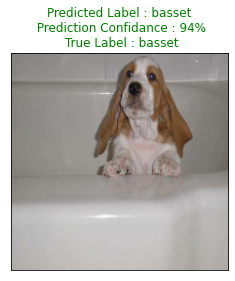

In [148]:
plot_pred(prediction_probabilities=preds, labels=valid_labels, images=valid_images, n=2)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer 
* Find the prediction using get_pred_label() 
*Find the top 10:
  * Prediction probabilities indexes 
  * Prediction probabilities values 
  * Prediction labels 
* Plot the top 10 prediction probability values and labels, coloring the true label green 

In [154]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # find the top 10 pred indexes
  top_10_index = pred_prob.argsort()[-10:][::-1]
  # find the top 10 values from the indexes
  top_10_values = pred_prob[top_10_index]
  # get the top 10 pred labels
  top_10_labels = unique_breeds[top_10_index]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_labels)), top_10_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_labels)),
             labels=top_10_labels,
             rotation="vertical")
  plt.title("{:2.0f}% {:2.0f}%".format(
                                    np.max(pred_prob)*100,
                                    np.max(pred_prob)*100))
  
  # Change color of true label
  if np.isin(true_label, top_10_labels):
    top_plot[np.argmax(top_10_labels == true_label)].set_color("green")
  else:
    pass

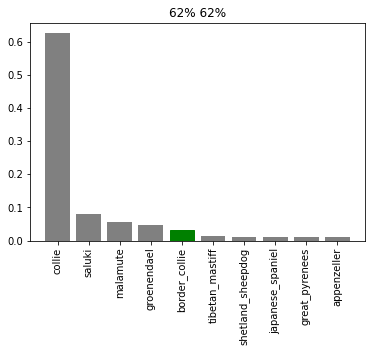

In [155]:
plot_pred_conf(prediction_probabilities=preds, labels=valid_labels, n=9)

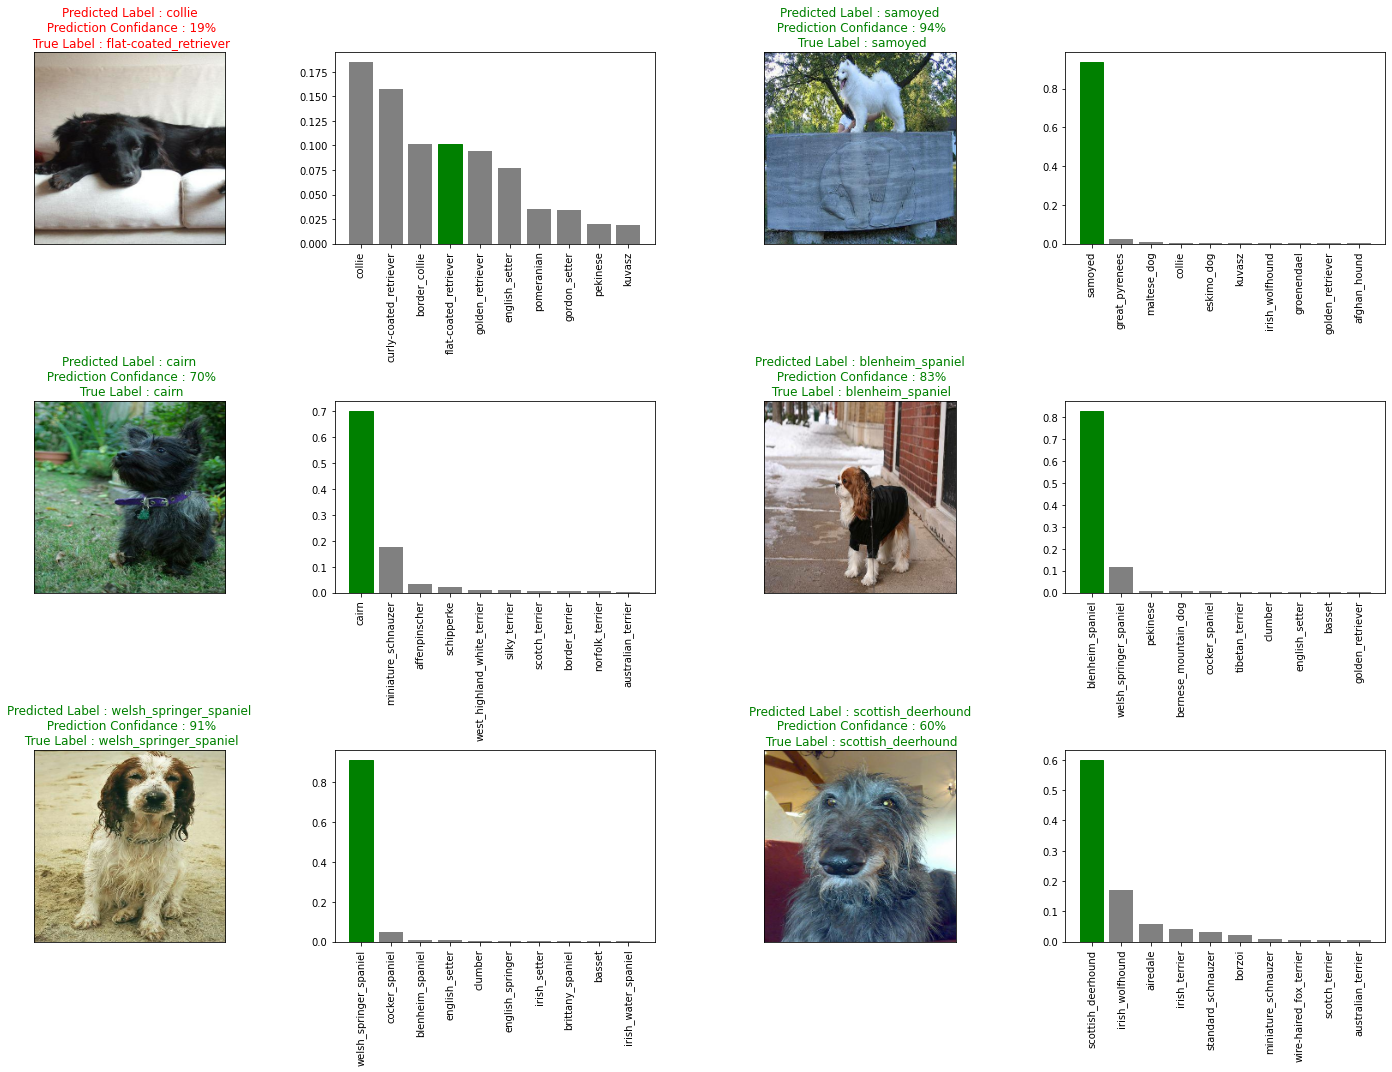

In [151]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=preds,
            labels=valid_labels,
            images=valid_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=preds,
                 labels=valid_labels,
                 n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

In [162]:
get_pred_label(preds[0])

'border_terrier'